In [5]:
%load_ext zipline


In [6]:
%zipline ingest --help

Usage: %zipline [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.
  --data-frequency [minute|daily]
                                  The data frequency of the simulation.
                                  [default: daily]
  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]
  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                          

In [7]:
%%zipline --bundle yahoo-bundle --trading-calendar XNSE --start '2017-01-01' --end '2019-12-15' -o nse_weekly.pickle --analyze analyze
from zipline.data import bundles
import os
import pandas as pd
from zipline.data.bundles import register, load
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.data.bundles.yahoo import yahoo_stock_data
from zipline.data.data_portal import DataPortal
from zipline.api import schedule_function
from zipline.pipeline.data import Column
from zipline.pipeline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
from trading_calendars.trading_calendar import TradingCalendar
from trading_calendars import get_calendar
import itertools
from zipline.pipeline.filters import StaticAssets
from zipline.utils.events import (
  date_rules,
  time_rules,
  Always,
  ComposedRule,
  Never,
  OncePerDay,
)
from zipline.api import (
  attach_pipeline,
  date_rules,
  order_target_percent,
  pipeline_output,
  record,
  schedule_function,
  symbols,
  symbol,
  sid,
)

start_session=pd.Timestamp('2017-01-01', tz='utc')
end_session=pd.Timestamp('2019-12-15', tz='utc')
import numpy as np
from scipy import stats
from zipline.api import order_target, record, symbol

register('yahoo-bundle',yahoo_stock_data,
    calendar_name="XNSE",
    start_session=start_session,
    end_session=end_session
)


bundle=load('yahoo-bundle')
all_assets=bundle.asset_finder.retrieve_all(bundle.asset_finder.sids)
# create a python set
symbols=set(
  str(asset.symbol) for asset in bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids)
)

list_symbols=list(symbols)
# print(type(list_symbols))
# print("list of symbols", list_symbols)
data_por=DataPortal(bundle.asset_finder,
                    get_calendar("XNSE"),
                    bundle.equity_daily_bar_reader.first_trading_day,
                    equity_minute_reader=bundle.equity_minute_bar_reader,
                    equity_daily_reader=bundle.equity_daily_bar_reader,
                    adjustment_reader=bundle.adjustment_reader)

close_prices=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                     pd.Timestamp('2007-02-02', tz='utc'), 'daily')
close_prices_list=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                          pd.Timestamp('2017-12-31', tz='utc'), 'daily')

list_sids=list(bundle.asset_finder.sids)


# print((close_prices))


def _slope(ts):
  x=np.arange(len(ts))
  slope, intercept, r_value, p_value, std_err=stats.linregress(x, ts)
  annualized_slope=(np.power(np.exp(slope), 250)-1)*100
  return annualized_slope*(r_value**2)


def initialize(context):
  """
  Called once at the start of the algorithm.
  """
  # Setting global parameters
  # context.assets = symbol('3MINDIA')
  context.market=symbol('NIFTY.NS')
  context.market_window=200
  context.momentum_window=90
  context.minimum_momentum=30
  context.number_of_stocks=10
  # --------------------------

  """Set
  up
  pipeline
  engine"""

  # Loader for pricing
  pipeline_loader=USEquityPricingLoader(
    bundle.equity_daily_bar_reader,
    bundle.adjustment_reader,
  )

  def choose_loader(column):
    if column in USEquityPricing.columns:
      return pipeline_loader

    raise ValueError(
      'No PipelineLoader registered for column %s.'%column
    )

  engine=SimplePipelineEngine(
    get_loader=choose_loader,
    calendar=get_calendar("XNSE").all_sessions,
    asset_finder=bundle.asset_finder,
  )

  pipe=make_pipeline()

  results=engine.run_pipeline(pipe,
                              pd.to_datetime('2017-01-02', utc=True),
                              pd.to_datetime('2019-12-13', utc=True))

  # print(results.head(1200))
  context.pipeline_data=results
  # print("type results",type(results))
  # Create our dynamic stock selector.
  attach_pipeline(pipe, 'make_pipeline')

  # Rebalance monthly
  # schedule_function(my_rebalance, date_rules.month_start(), time_rules.market_open(hours=1))

  """close_prices_list=data_por.get_spot_value(bundle.asset_finder.retrieve_all(bundle.asset_finder.equities_sids), 'close',
                                          pd.Timestamp('2018-12-03', tz='utc'), 'daily')"""

  # print("type of close prices", type(close_prices_list))
  #schedule_function(my_rebalance, date_rules.week_end(days_offset=2))
  schedule_function(my_rebalance, date_rules.month_end())


#


def make_pipeline():
  """
  This will return the top 500 US stocks by market cap, dynically updated.
  """
  # Base universe set to the Q500US
  base_universe=(StaticAssets(all_assets))

  # print(type(base_universe))
  yesterday_close=close_prices_list

  pipe=Pipeline(
    screen=base_universe,
    columns={
      'close': USEquityPricing.close.latest,
      'volume': USEquityPricing.volume.latest,
      'open': USEquityPricing.open.latest,
    }
  )
  return pipe


def get_change(current, previous):
  if current==previous:
    return 100.0
  try:
    return ((current-previous)/previous)*100.0
  except ZeroDivisionError:
    return 0


def before_trading_start(context, data):
  print("inside before trading start")
  # context.pipeline_data=pipeline_output(name='make_pipeline')


def handle_data(context, data):
  # context.pipeline_data=pipeline_output('make_pipeline')
  # window_1 = data.history(context.assets,'high',1, '1d')
  # print(window_1)
  # schedule_function(my_rebalance(context, data), date_rules.week_end(days_offset=3))
  pass


def my_rebalance(context, data):
  """
  Our monthly rebalancing
  """
  # context.pipeline_data=pipeline_output('us_500')
  # context.output=pipeline_output('us_500')  # update the current top 500 us stocks
  # context.pipeline_data=pipeline_output('us_500')
  algo_run_timestamp=str(context.datetime)+"T00:00.000000000"
  print("has hit rebalance on date", algo_run_timestamp)
  market_history=data.history(context.market, "close", context.market_window, "1d")  ##NIFTY##
  market_price_algo_day=market_history.get(algo_run_timestamp)
  market_sma_200=data.history(context.market, 'close', bar_count=200, frequency="1d").mean()
  market_cond=market_price_algo_day>market_sma_200
  market_chg=get_change(market_price_algo_day, market_sma_200)
  print("market chg is", market_chg)
  market_chg_cond=(market_chg<0.5)
  if (market_chg_cond):
    print(str(algo_run_timestamp))
    print("nothing to buy")
    return

  my_dict={}
  for x in range(len(list_sids)):
    my_dict[x]=sid(list_sids[x])

  context.security_list=list(my_dict.values())

  momentum_list=np.log(data.history(context.security_list, "close", context.momentum_window, "1d")).apply(_slope)

  # print("momentum list is", momentum_list.sort_values(ascending=False))
  ranking_table=momentum_list.sort_values(ascending=False)  # Sorted

  # print("price at a particular time",market_history.get(algo_run_timestamp))

  # print("market history",market_history)
  # market details
  print("Nifty current price and 200Sma", market_price_algo_day, market_sma_200)
  buy_list=ranking_table[:context.number_of_stocks]  # These we want to buy
  print("buy list", buy_list)
  print("context portfolio positions", context.portfolio.positions)
  # Let's trade!
  for security in context.portfolio.positions:
    if security not in buy_list:
      print("making this", security, 0)
      order_target(security, 0)  # If a stock in the portfolio is not in buy list, sell it!

  for security in context.security_list:
    if security in buy_list:
      sma_100=data.history(security, 'price', bar_count=100, frequency="1d").mean()
      sma_50=data.history(security, 'price', bar_count=50, frequency="1d").mean()
      print("security details", security)

      if buy_list[security]<context.minimum_momentum:
        weight=0.0
      else:
        weight=1.0/context.number_of_stocks  # Equal size to keep simple
      cond1=sma_50>sma_100
      cond2=market_price_algo_day>market_sma_200
      print("security 50 and 100 sma", sma_50, sma_100)

      if (cond1 and cond2):
        order_target_percent(security, weight)  # Trade!
        print("ordering this", security)

            
        


NoSuchOption: no such option: --analyze

In [4]:
import pandas as pd
perf = pd.read_pickle('nse_weekly.pickle') # read in perf DataFrame

In [5]:
perf.to_csv("results.csv")

In [6]:
for items in perf.orders.iteritems():
    if(items[1]):
        print(items)
     
      
        

(Timestamp('2017-01-31 10:00:00+0000', tz='UTC'), [{'created': Timestamp('2017-01-31 10:00:00+0000', tz='UTC'), 'filled': 0, 'stop_reached': False, 'amount': 7958, 'stop': None, 'id': '99a1a5715f6d4e4fb241f775e20697cb', 'limit': None, 'commission': 0, 'sid': Equity(29 [INFIBEAM.NS]), 'status': 0, 'limit_reached': False, 'reason': None, 'dt': Timestamp('2017-01-31 10:00:00+0000', tz='UTC')}, {'created': Timestamp('2017-01-31 10:00:00+0000', tz='UTC'), 'filled': 0, 'stop_reached': False, 'amount': 5858, 'stop': None, 'id': 'cb161ec026b64fe39999f2e8f582b66d', 'limit': None, 'commission': 0, 'sid': Equity(82 [SWANENERGY.NS]), 'status': 0, 'limit_reached': False, 'reason': None, 'dt': Timestamp('2017-01-31 10:00:00+0000', tz='UTC')}, {'created': Timestamp('2017-01-31 10:00:00+0000', tz='UTC'), 'filled': 0, 'stop_reached': False, 'amount': 6199, 'stop': None, 'id': 'eb51a3dce05e4ac6bcbedcc94f6a8d90', 'limit': None, 'commission': 0, 'sid': Equity(124 [SONATSOFTW.NS]), 'status': 0, 'limit_reac

In [7]:
# transactions
for items in perf.transactions.iteritems():
    if(items[1]):
        print(items)
        
        
    

(Timestamp('2017-02-01 10:00:00+0000', tz='UTC'), [{'order_id': '67f76e8ca48d4eba8223cf45d0885275', 'sid': Equity(216 [BALMLAWRIE.NS]), 'amount': 5731, 'price': 173.436675, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': 'cb161ec026b64fe39999f2e8f582b66d', 'sid': Equity(82 [SWANENERGY.NS]), 'amount': 5858, 'price': 171.387651, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '350f6de6471947dfbb2195c2c83b8d79', 'sid': Equity(372 [ADANITRANS.NS]), 'amount': 15810, 'price': 64.9814745, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '5a4d4aad7d7a4e7582c64841c0226964', 'sid': Equity(325 [KRBL.NS]), 'amount': 2718, 'price': 371.593704, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '09560736f9344b0fa0711831d33a5829', 'sid': Equity(162 [MOIL.NS]), 'amount': 6475, 'price': 159.211566, 'commission': None, 'dt': Timestamp('2017-02-01

In [8]:
for items in perf.pnl.iteritems():
    if(items[1]):
       
        print(items[1])
        


-5116.5187494996935
-55813.25600000098
19096.616000000387
46239.16200000048
44941.03800000064
-27148.357000000775
-20486.732999999076
-179547.20299999975
-18047.27199999988
-53471.77300000191
-198051.40899999812
49904.61799999885
-14863.804999999702
21320.256999999285
160061.03700000048
-27666.859000001103
-14568.590999998152
5835.452999997884
16179.24700000137
43858.952494999394
-148809.8839999996
166788.28299999796
84726.35700000264
100480.9729999993
-59724.81300000101
-95303.13299999759
-22986.299000002444
207886.12399999984
2973.3750000018626
77453.00100000016
-53523.82600000128
107791.57500000112
-27423.2060000021
-75177.06099999882
349423.27300000004
-75172.65100000054
-40044.59999999963
157622.22000000067
42348.5989999976
93022.13000000268
-113559.22699999996
95640.99572400004
432539.3140000012
-38358.16400000267
-114645.41600000113
96312.1790000014
101912.70299999975
-83266.17300000042
47438.42300000228
259871.2960000001
-2872.3620000015944
22994.978000001982
310576.5869999975


67768.89900000021
-57715.72699999809
-263650.78599999845
169980.1799999997
266013.42099999264
133742.75000000745
982076.6939999945
131086.5520000048
-34711.61400000751
-24310.27999999374
352418.8219999932
-77905.9429999888
-272173.9980000034
41781.10999999568
-102798.13799998909
62301.406999990344
64513.250000003725
22668.64599999413
-224086.59799999744
-128143.75400000438
436705.40700000897
81753.48099999875
618889.9829999954
586258.7881210037
-109181.67080650479
-313879.34600000456
-349603.5259999931
448892.924999997
-386934.25699999556
254683.8529999964
482978.65700000897
793827.91599999
409790.1130000055
-64272.83799999952
-101010.9980000034
-358203.4880000055
-899731.4499999993
-251039.3379999958
230413.29199999943
405154.3669999987
-143143.85999999568
-548145.6160000041
53249.45120450482
242476.13999999315
-191190.82799999788
-312611.85199999064
-1095540.4510000087
-9452.373999994248
148999.6579999961
-1106391.1009999998
589051.4650000036
-214957.68300000578
530531.6389999986
202

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])
perf.portfolio_value.plot(ax=ax[0])
ax[0].set_ylabel('portfolio value in rupees')

#asset


Text(0, 0.5, 'portfolio value in rupees')

In [10]:


# mark transactions
perf_trans = perf.loc[[t != [] for t in perf.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]


In [11]:
for b in buys.transactions:
    print(b)

[{'order_id': '67f76e8ca48d4eba8223cf45d0885275', 'sid': Equity(216 [BALMLAWRIE.NS]), 'amount': 5731, 'price': 173.436675, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': 'cb161ec026b64fe39999f2e8f582b66d', 'sid': Equity(82 [SWANENERGY.NS]), 'amount': 5858, 'price': 171.387651, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '350f6de6471947dfbb2195c2c83b8d79', 'sid': Equity(372 [ADANITRANS.NS]), 'amount': 15810, 'price': 64.9814745, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '5a4d4aad7d7a4e7582c64841c0226964', 'sid': Equity(325 [KRBL.NS]), 'amount': 2718, 'price': 371.593704, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '09560736f9344b0fa0711831d33a5829', 'sid': Equity(162 [MOIL.NS]), 'amount': 6475, 'price': 159.211566, 'commission': None, 'dt': Timestamp('2017-02-01 10:00:00+0000', tz='UTC')}, {'order_id': '56efce9

In [12]:
sells

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-03-01 10:00:00+00:00,0.086655,-0.020735,-0.101748,0.072459,0.063873,-0.053941,3.473572e+04,-3.198293e+03,9.795853e+06,9.795853e+06,...,0.0,0.0,0,-1.757916,-3.793402e+04,9.786730e+06,9.786730e+06,41,[{'order_id': '0ed777257a954ce6877d5f96beb306f...,0.0
2017-05-02 10:00:00+00:00,0.164319,0.185497,0.485889,0.064041,0.070561,0.292704,1.176015e+04,-1.445591e+05,1.199953e+07,1.199953e+07,...,0.0,0.0,0,6.871904,-1.563193e+05,1.200534e+07,1.200534e+07,81,[{'order_id': 'e2808bc2c73f48f9aed7d8818328cbb...,0.0
2017-07-03 10:00:00+00:00,0.217372,0.422133,0.698394,0.078661,0.072456,0.265432,5.579959e+05,-4.009406e+05,1.462227e+07,1.462227e+07,...,0.0,0.0,0,6.333898,-9.589365e+05,1.484282e+07,1.484282e+07,124,[{'order_id': 'c996f3353c4a49409214828371e8dfc...,0.0
2017-07-04 10:00:00+00:00,0.219099,0.460050,0.747449,0.078661,0.072169,0.259687,2.815085e+05,-1.194321e+05,1.471993e+07,1.471993e+07,...,0.0,0.0,0,6.770464,-4.009406e+05,1.462227e+07,1.462227e+07,125,[{'order_id': 'dd89f5dc3c224e85ac91d905369c075...,0.0
2017-07-05 10:00:00+00:00,0.224380,0.518520,0.816613,0.081155,0.071919,0.283608,1.380420e+05,1.860992e+04,1.516659e+07,1.516659e+07,...,0.0,0.0,0,7.434645,-1.194321e+05,1.471993e+07,1.471993e+07,126,[{'order_id': 'dd89f5dc3c224e85ac91d905369c075...,0.0
2017-07-06 10:00:00+00:00,0.223906,0.508965,0.799321,0.071269,0.072945,0.308901,6.870808e+04,8.731799e+04,1.500233e+07,1.500233e+07,...,0.0,0.0,0,7.275746,1.860992e+04,1.516659e+07,1.516659e+07,127,[{'order_id': 'dd89f5dc3c224e85ac91d905369c075...,0.0
2017-09-01 10:00:00+00:00,0.249637,0.717260,0.748832,0.101295,0.073791,0.699219,-3.983667e+05,-4.255252e+05,1.759812e+07,1.759812e+07,...,0.0,0.0,0,5.744792,-2.715848e+04,1.674640e+07,1.674640e+07,166,[{'order_id': '14c10bb0f2ab4fed98bf66fe21e0442...,0.0
2017-09-04 10:00:00+00:00,0.248952,0.714947,0.742210,0.101295,0.073572,0.699932,4.786121e+05,5.308693e+04,1.709639e+07,1.709639e+07,...,0.0,0.0,0,5.713485,-4.255252e+05,1.759812e+07,1.759812e+07,167,[{'order_id': '2e8e22a27a6e4a09a93ced1d0f5c23a...,0.0
2017-09-05 10:00:00+00:00,0.249206,0.751946,0.784582,0.093386,0.073966,0.649533,1.630528e+05,2.161398e+05,1.730332e+07,1.730332e+07,...,0.0,0.0,0,5.915652,5.308693e+04,1.709639e+07,1.709639e+07,168,[{'order_id': '2e8e22a27a6e4a09a93ced1d0f5c23a...,0.0
2017-10-03 10:00:00+00:00,0.263933,0.981878,0.859059,0.118748,0.071826,0.644489,-1.800009e+05,3.613888e+04,1.978264e+07,1.978264e+07,...,0.0,0.0,0,5.925225,2.161398e+05,1.885549e+07,1.885549e+07,187,[{'order_id': 'cc333a3ee8254659ad99e0a8e68b3f5...,0.0


In [3]:
import pandas as pd
import pyfolio as pf

In [4]:
results = pd.read_pickle('nse_weekly.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

ValueError: not enough values to unpack (expected 4, got 3)

/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5, 0, 'Date')

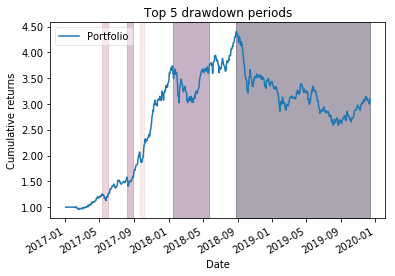

In [15]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

In [ ]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, round_trips=True)

Start date,2017-01-02
End date,2019-12-13
Total months,34
,Backtest
Annual return,48.2%
Cumulative returns,209.4%
Annual volatility,25.7%
Sharpe ratio,1.66
Calmar ratio,1.17
Stability,0.48
Max drawdown,-41.2%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.22,2018-08-28,2019-08-23,NaT,NaN
1,19.06,2018-01-15,2018-02-06,2018-05-25,95
2,11.26,2017-08-07,2017-08-10,2017-08-28,16
3,10.28,2017-05-11,2017-05-24,2017-06-01,16
4,9.88,2017-09-20,2017-09-27,2017-10-05,12


Stress Events,mean,min,max
New Normal,0.17%,-7.59%,6.50%


Top 10 long positions of all time,max
sid,
IBULISL.NS,20.20%
KIOCL.NS,18.72%
IBVENTURES.NS,17.73%
ASTRAZEN.NS,15.60%
ITI.NS,15.30%
ADANIGREEN.NS,14.49%
HDFCAMC.NS,14.44%
BAJFINANCE.NS,14.34%
HEG.NS,13.49%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
IBULISL.NS,20.20%
KIOCL.NS,18.72%
IBVENTURES.NS,17.73%
ASTRAZEN.NS,15.60%
ITI.NS,15.30%
ADANIGREEN.NS,14.49%
HDFCAMC.NS,14.44%
BAJFINANCE.NS,14.34%
HEG.NS,13.49%


In [1]:
def analyze(context, perf):
    fig = plt.figure(figsize=(12, 8))
    
    # First chart
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results')
    ax.semilogy(perf['portfolio_value'], linestyle='-', 
                label='Equity Curve', linewidth=3.0)
    ax.legend()
    ax.grid(False)
    
    # Second chart
    ax = fig.add_subplot(312)
    ax.plot(perf['gross_leverage'], 
            label='Exposure', linestyle='-', linewidth=1.0)
    ax.legend()
    ax.grid(True)

    # Third chart
    ax = fig.add_subplot(313)
    ax.plot(perf['returns'], label='Returns', linestyle='-.', linewidth=1.0)
    ax.legend()
    ax.grid(True)